<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/pytorch/2_2_RNN_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load Data

In [6]:
file = "/content/gdrive/MyDrive/neural_data/TimeSeriesData/Alcohol_Sales.csv"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
df = pd.read_csv(file,index_col=0,parse_dates=True)
len(df)

325

In [9]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [8]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

## Plotting time series data

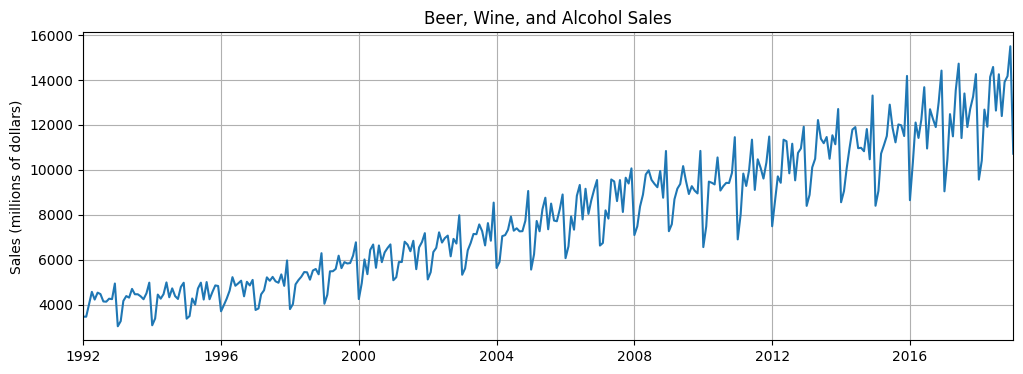

In [10]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data

In [11]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [12]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [14]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [16]:
train_norm.min(), train_norm.max(), train_norm.mean()

(-1.0, 1.0, -0.2041940178388313)

In [17]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM

In [18]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [19]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

## Define the model